In [1]:
from itertools import product
import numpy as np

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import ParameterGrid

from scipy.stats import norm
from brown_box.utils import DiscreteKernel
from brown_box.utils import HyperTransformer

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

/mnt/workspace/brown_box_submissions/deep_jkl


## Define some multivariate function

In [2]:
def target(x, f):
    if f == "exp":
        return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)
    if f == "sin":
        return np.sin(-(x - 2)**2) + np.sin(-(x - 6)**2/10) + 1/ (x**2 + 1)
    if f == "cos":
        return np.cos(-(x - 2)**2) + np.cos(-(x - 6)**2/10) + 1/ (x**2 + 1)

### Plot some configurations

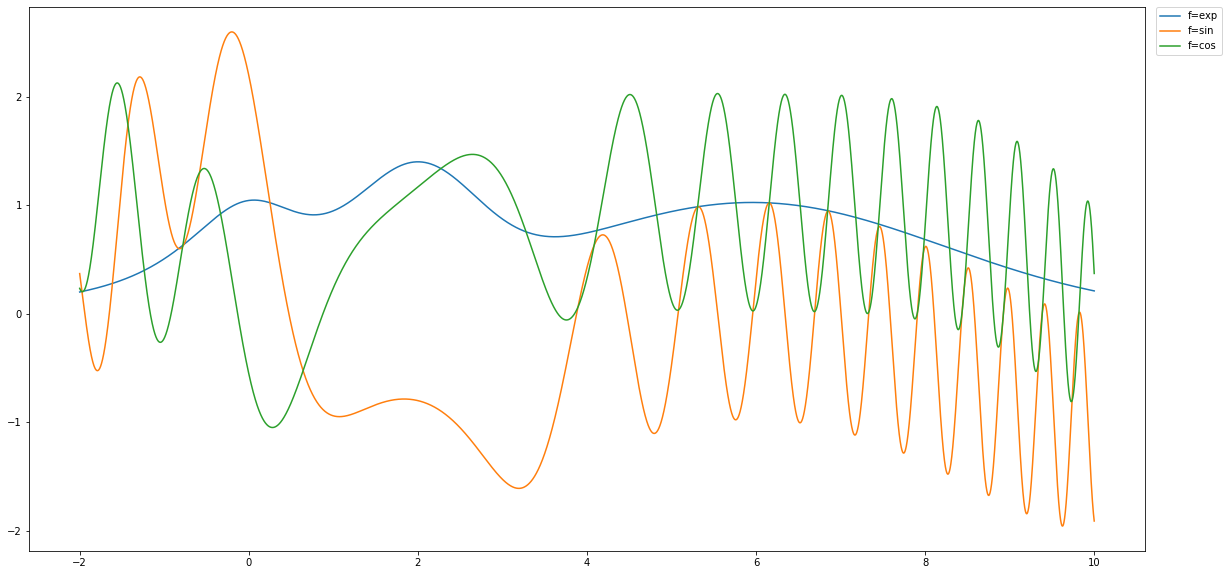

In [3]:
fig = plt.figure(figsize=(20,10))
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
for f in ["exp", "sin", "cos"]:
    y = target(x, f)
    plt.plot(x, y, label=f"f={f}")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

## Define problem

In [4]:
api_config = {
    "x": {"type": "real", "space": "linear", "range": (-2, 10)},
    "f": {"type": "cat", "values": ["exp", "sin", "cos"]},
}
tr = HyperTransformer(api_config)

In [5]:
gp = GaussianProcessRegressor(
    kernel=DiscreteKernel(Matern(nu=2.5), tr),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
)


## Get some init points

In [6]:
X = [
        {
            "x": 0.5,
            "f": "exp",
        },
        {
            "x": 3.5,
            "f": "exp",
        },
        {
            "x": 5.5,
            "f": "exp",
        },
        {
            "x": 0.5,
            "f": "cos",
        },
        {
            "x": 3.5,
            "f": "sin",
        },
        {
            "x": 5.5,
            "f": "cos",
        },
]
x = {k: [dic[k] for dic in X] for k in X[0]}

# Evaluate target in those points

In [7]:
y = np.asarray([target(**p) for p in X])

In [8]:
x["x"]

[0.5, 3.5, 5.5, 0.5, 3.5, 5.5]

In [9]:
_X = tr.to_real_space(**x)

## Fit Gaussan Process regressor

In [10]:
gp.fit(_X, y)

GaussianProcessRegressor(alpha=1e-06, copy_X_train=True,
             kernel=DiscreteKernel(), n_restarts_optimizer=5,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

## Sample GP 
let's have a constant X and sample over real space, what is 4 dimensional due to one-hot encoding

We will set the fist onehot to (0, 0.5, 0) and then we will gradually add (0.11, 0.0, 0.0) and watch changes in EI, it should change in discrete steps (according to greatest index)

In [11]:
_x0 = tr.to_real_space(x=[4], f=["sin"])*0.5
_x = []
p = np.linspace(-2, 10, 100)
q = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(p, q)

for _p, _q in product(p, q):
    _x.append(np.asarray([_p, _q, 0.5, 0.0]))
_x=np.stack(_x,0)

In [12]:
%time
mean, std = gp.predict(_x, return_std=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


## Calculate Expected Improvement

In [13]:
z = (mean - max(y)) / std
ei = mean * norm.cdf(z) + std * norm.pdf(z)

## Plot predicted function and confidence

This will look so insane, but every function category is ploted in whole range of x. You can see that in points where we evaluated we are equal, other points are approximated with som error, filling curve shows confidence, which is determined by number of points we have sampled in the space.

Text(0, 0.5, 'target')

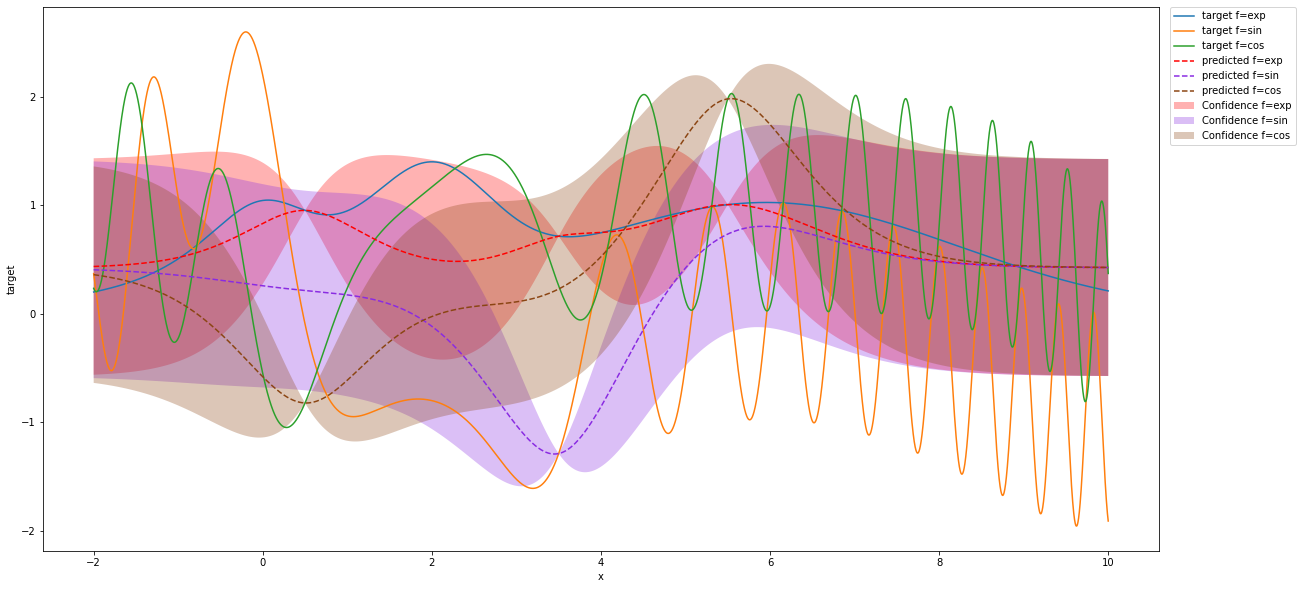

In [14]:
fig = plt.figure(figsize=(20,10))
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
for f in ["exp", "sin", "cos"]:
    y = target(x, f)
    plt.plot(x, y,linestyle="-", label=f"target f={f}")

x = np.linspace(-2, 10, 10000).reshape(-1, 1)
_c = {"exp":"red","sin":"blueviolet","cos":"saddlebrown",}
for f in ["exp", "sin", "cos"]:
    _x = tr.to_real_space(x=x, f=[f]*10000)
    y, std = gp.predict(_x, return_std=True)
    plt.plot(x, y,linestyle="--", color=_c[f], label=f"predicted f={f}")
    plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y-std, (y+std)[::-1]]),alpha=.3, fc=_c[f], ec='None', label=f"Confidence f={f}")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.xlabel("x")
plt.ylabel("target")

## Plot Expected improvement

-- for sake of simplicity, we sample only one class weight

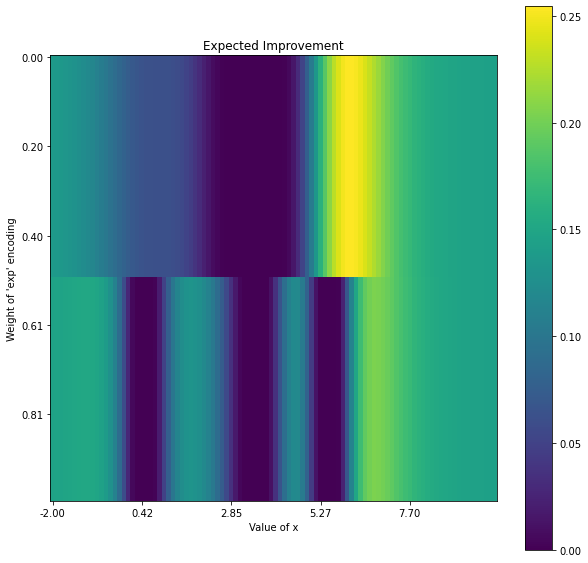

In [15]:

fig = plt.figure(figsize=(10,10))
ax = plt.imshow(ei.reshape(100, 100).T)
x_positions = np.arange(0, 100)[::20]
x_labels = [f"{_s:.2f}" for _s in p[::20]]
plt.xticks(x_positions, x_labels)
y_positions = np.arange(0, 100)[::20]
y_labels = [f"{_s:.2f}" for _s in q[::20]]
plt.yticks(y_positions, y_labels)
plt.xlabel("Value of x")
plt.ylabel("Weight of 'exp' encoding")
plt.title("Expected Improvement")
fig.colorbar(ax)
fig.show()